In [1]:
!pip install roboschool==1.0.48 gym==0.15.4
!pip install box2d-py
!pip install pybullet

In [2]:
############################### Import libraries ###############################


import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import numpy as np

import gym
import roboschool
import pybullet_envs

In [3]:
################################## set device ##################################

print("============================================================================================")


# set device to cpu or cuda
device = torch.device('cpu')

if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
    
print("============================================================================================")

Device set to : GeForce RTX 2080 SUPER


In [4]:
################################ rollout buffer ###############################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)

        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )

        
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")
    
    def forward(self):
        raise NotImplementedError
    

    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        
        return action.detach(), action_logprob.detach()
    

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy
        

In [6]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):
        
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")

        print("--------------------------------------------------------------------------------------------")


    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()


    def update(self):

        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        
        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()   
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        
        
       


In [7]:

print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "CartPole-v1"
has_continuous_action_space = False

max_ep_len = 400                    # max timesteps in one episode
max_training_timesteps = int(1e5)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(2e4)      # save model frequency (in num timesteps)

action_std = None


#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name)

env = gym.make(env_name)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n



###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################


################### checkpointing ###################

run_num_pretrained = 0      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()
    current_ep_reward = 0

    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, done, _ = env.step(action)
        
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

            print_running_reward = 0
            print_running_episodes = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")







training environment name : CartPole-v1
current logging run number for CartPole-v1 :  1
logging at : PPO_logs/CartPole-v1//PPO_CartPole-v1_log_1.csv
save checkpoint path : PPO_preTrained/CartPole-v1/PPO_CartPole-v1_0_0.pth
--------------------------------------------------------------------------------------------
max training timesteps :  100000
max timesteps per episode :  400
model saving frequency : 20000 timesteps
log frequency : 800 timesteps
printing average reward over episodes in last : 1600 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  4
action space dimension :  2
--------------------------------------------------------------------------------------------
Initializing a discrete action space policy
--------------------------------------------------------------------------------------------
PPO update frequency : 1600 timesteps
PPO K epochs :  40
PPO epsilon clip :  0.2
discount factor (gamma) :

loading data from : PPO_logs/CartPole-v1//PPO_CartPole-v1_log_0.csv
data shape :  (125, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/CartPole-v1//PPO_CartPole-v1_log_1.csv
data shape :  (125, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/CartPole-v1//PPO_CartPole-v1_fig_0.png


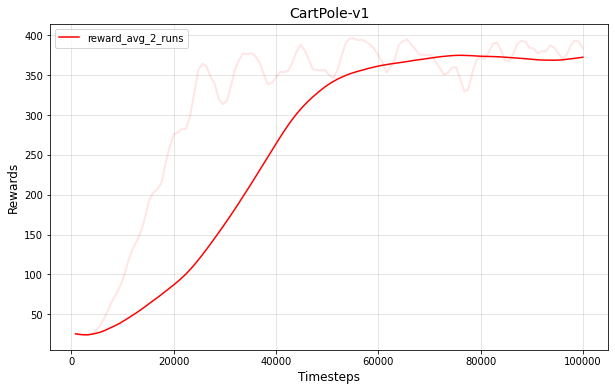

In [8]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

env_name = 'CartPole-v1'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = True    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)
    
    print("data shape : ", data.shape)
    
    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
        
        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



# ax.set_yticks(np.arange(0, 1800, 200))
# ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()

In [9]:


#### to render on colab / server / headless machine install virtual display libraries

!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1
